# Attention Map Editing

If you want to mask of focus on specific elements of the attention map you have to go to models/transformer.py and edit either the mask (line 86) or the focus (line 87) variable. The options are: None, uniform, pc_to_pc, pc_to_pc_diag, img_to_pc, pc_to_img, img_to_img, cross_attention. 

In [13]:
import seaborn as sns
import imageio
import importlib
from PIL import Image
import matplotlib.pyplot as plt
import math
import torch
import nopdb
from tqdm.auto import tqdm
import numpy as np

import sys
# Detect local paths
local_path = !pwd
local_path = local_path[0][:-5]
sys.path.append(local_path + 'src/')

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [14]:
torch.cuda.empty_cache()

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M' # use base300M or base1B for better results
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [16]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [18]:
# Path
path = '../src/point_e/examples'
# Load an image to condition on.
img = Image.open(path +'/example_data/cube_stack.jpg')
import sys

def sample_from_model(breakpoint):
    samples = None
    k = 0
    with nopdb.capture_call(base_model.backbone.resblocks[-1].attn.attention.forward) as attn_call:
        for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
            if x.shape[2] == 1024:
                samples = x
                if k == breakpoint:
                    break
                k += 1
            else:
                break
            
    attention_probs = attn_call.locals['weight'][0]

    # Average across all heads
    avg_attn = torch.mean(attention_probs, dim = 0)
    
    # Est. self attention
    pc_self_attn = avg_attn[257:, 257:]
    
    # Est. cross attention
    img_self_attn = avg_attn[:257, :257]

    # Est. cross attention
    img_to_pc_cross_attn = avg_attn[:257, 257:]

    # Est. cross attention
    pc_to_img_cross_attn = avg_attn[257:, :257]

    pc_self_attn = pc_self_attn.cpu()
    img_self_attn = img_self_attn.cpu()
    img_to_pc_cross_attn = img_to_pc_cross_attn.cpu()
    pc_to_img_cross_attn = pc_to_img_cross_attn.cpu()
    avg_attn = avg_attn.cpu()
    
    return pc_self_attn, img_self_attn, img_to_pc_cross_attn, pc_to_img_cross_attn, avg_attn, samples

In [19]:
breakpoints = [0, 10, 20, 30, 40, 50, 60, -1]
time = [0, 1, 2, 3, 4, 5, 6, 7]

0it [00:00, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '../src/point_e/examples/Figures/pc2pc/0.png'

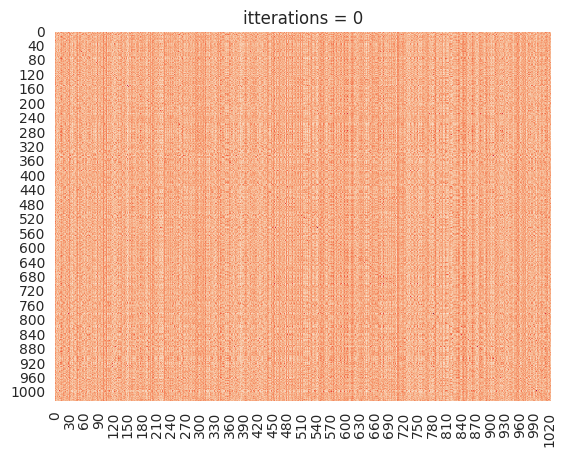

In [12]:
"""
Run model 
"""

frames = []

for k in breakpoints:
    pc_self_attn, img_self_attn, img_to_pc_cross_attn, pc_to_img_cross_attn, avg_attn, samples = sample_from_model(k)
    
    ax = sns.heatmap(pc_self_attn, cmap = 'rocket_r', cbar=False)
    plt.title('itterations = ' + str(k))
    plt.savefig(path + '/Figures/pc2pc/' +str(k) + '.png', bbox_inches='tight')
    plt.close()

    ax = sns.heatmap(img_self_attn, cmap = 'rocket_r', cbar=False)
    plt.title('itterations = ' + str(k))
    plt.savefig(path + '/Figures/img2img/' +str(k) + '.png', bbox_inches='tight')
    plt.close()

    ax = sns.heatmap(img_to_pc_cross_attn, cmap = 'rocket_r', cbar=False)
    plt.title('itterations = ' + str(k))
    plt.savefig(path + '/Figures/img2pc/' +str(k) + '.png', bbox_inches='tight')
    plt.close()

    ax = sns.heatmap(pc_to_img_cross_attn, cmap = 'rocket_r', cbar=False)
    plt.title('itterations = ' + str(k))
    plt.savefig(path + '/Figures/pc2img/' +str(k) + '.png', bbox_inches='tight')
    plt.close()
    
    ax = sns.heatmap(avg_attn, cmap = 'rocket_r', cbar=False)
    plt.title('itterations = ' + str(k))
    plt.savefig(path + '/Figures/full/' +str(k) + '.png', bbox_inches='tight')
    plt.close()

    pc = sampler.output_to_point_clouds(samples)[0]
    ax = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))
    plt.title('iterations = ' + str(k))
    plt.savefig(path + '/Figures/Diffusion_gif_2/fig' + str(k) + '.png', bbox_inches='tight')
    plt.close()

    
  

In [8]:
# """
# Make Gifs
# """

images = [path + '/Figures/Diffusion_gif_2/fig' + str(k) + '.png' for k in breakpoints]
frames = []
for t in time:
    image = imageio.imread(images[t])
    frames.append(image)

imageio.mimsave(path + '/Figures/Diffusion_gif_2/Diffusion_at_scale.gif', # output gif
                frames,          # array of input frames
                duration = 2000)         # optional: frames per second  

images = [path + '/Figures/full/' + str(k) + '.png' for k in breakpoints]
frames = []
for t in time:
    image = imageio.imread(images[t])
    frames.append(image)
    
imageio.mimsave(path + '/Figures/full/full_attention.gif', frames, duration=2000)

images = [path + '/Figures/pc2pc/' + str(k) + '.png' for k in breakpoints]
frames = []
for t in time:
    image = imageio.v2.imread(images[t])
    frames.append(image)
    
imageio.mimsave(path + '/Figures/pc2pc/pc2pc_self_attention.gif', frames, duration=2000)

images = [path + '/Figures/img2img/' + str(k) + '.png' for k in breakpoints]
frames = []
for t in time:
    image = imageio.v2.imread(images[t])
    frames.append(image)
    
imageio.mimsave(path + '/Figures/img2img/img2img_self_attention.gif', frames, duration=2000)

images = [path + '/Figures/img2pc/' + str(k) + '.png' for k in breakpoints]
frames = []
for t in time:
    image = imageio.v2.imread(images[t])
    frames.append(image)
    
imageio.mimsave(path + '/Figures/img2pc/img2pc_attention.gif', frames, duration=2000)

images = [path + '/Figures/pc2img/' + str(k) + '.png' for k in breakpoints]
frames = []
for t in time:
    image = imageio.v2.imread(images[t])
    frames.append(image)
    
imageio.mimsave(path + '/Figures/pc2img/pc2img_attention.gif', frames, duration=2000)

<ipython-input-8-b04075ddebef>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(images[t])
<ipython-input-8-b04075ddebef>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(images[t])
